<a href="https://colab.research.google.com/github/yuji-sgs/child-mind-institute/blob/main/Feature_Enginnering/LGBM_ver01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna colorama catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

# Data Set

In [4]:
%%time

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.4 µs


In [78]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/test.csv')
data_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/data_dictionary.csv')
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/sample_submission.csv')

In [6]:
train_ts = load_time_series("/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/series_train.parquet")
test_ts = load_time_series("/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


# Feature Engineering

In [79]:
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    # df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    # df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']

    return df

# Basic Preprocess

In [80]:
train = feature_engineering(train)
test = feature_engineering(test)

In [81]:
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [82]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age',
                # 'BMI_Internet_Hours', 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW',
                # 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height',
                # 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW',
                'sii']

In [83]:
featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii') # siiが欠損する行を削除

In [84]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season',
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

In [85]:
def update(df):
    for c in cat_c:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

In [86]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)

    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2736, 157) || Test Shape : (20, 156)


In [87]:
%%time

train.head()

CPU times: user 599 µs, sys: 77 µs, total: 676 µs
Wall time: 626 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,sii,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,84.386578,15.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,126.320313,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,166.486961,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0

In [88]:
%%time

test.head()

CPU times: user 860 µs, sys: 4 µs, total: 864 µs
Wall time: 725 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,84.386578,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,126.320313,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,166.486961,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,3

# Modeling | Single LGBM

In [89]:
%%time

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):

    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    train_S = []
    test_S = []

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)

        test_preds[:, fold] = model.predict(test_data)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded),
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 15.3 µs


In [90]:
%%time

Params7 = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2,
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} # CV : 0.4094 | LB : 0.471

Light = lgb.LGBMRegressor(**Params7,random_state=SEED, verbose=-1,n_estimators=200)
Submission,model = TrainML(Light,test)

Training Folds: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

Mean Train QWK --> 0.8297
Mean Validation QWK ---> 0.3866


----> || Optimized QWK SCORE ::  0.451
CPU times: user 19.1 s, sys: 104 ms, total: 19.2 s
Wall time: 19.4 s


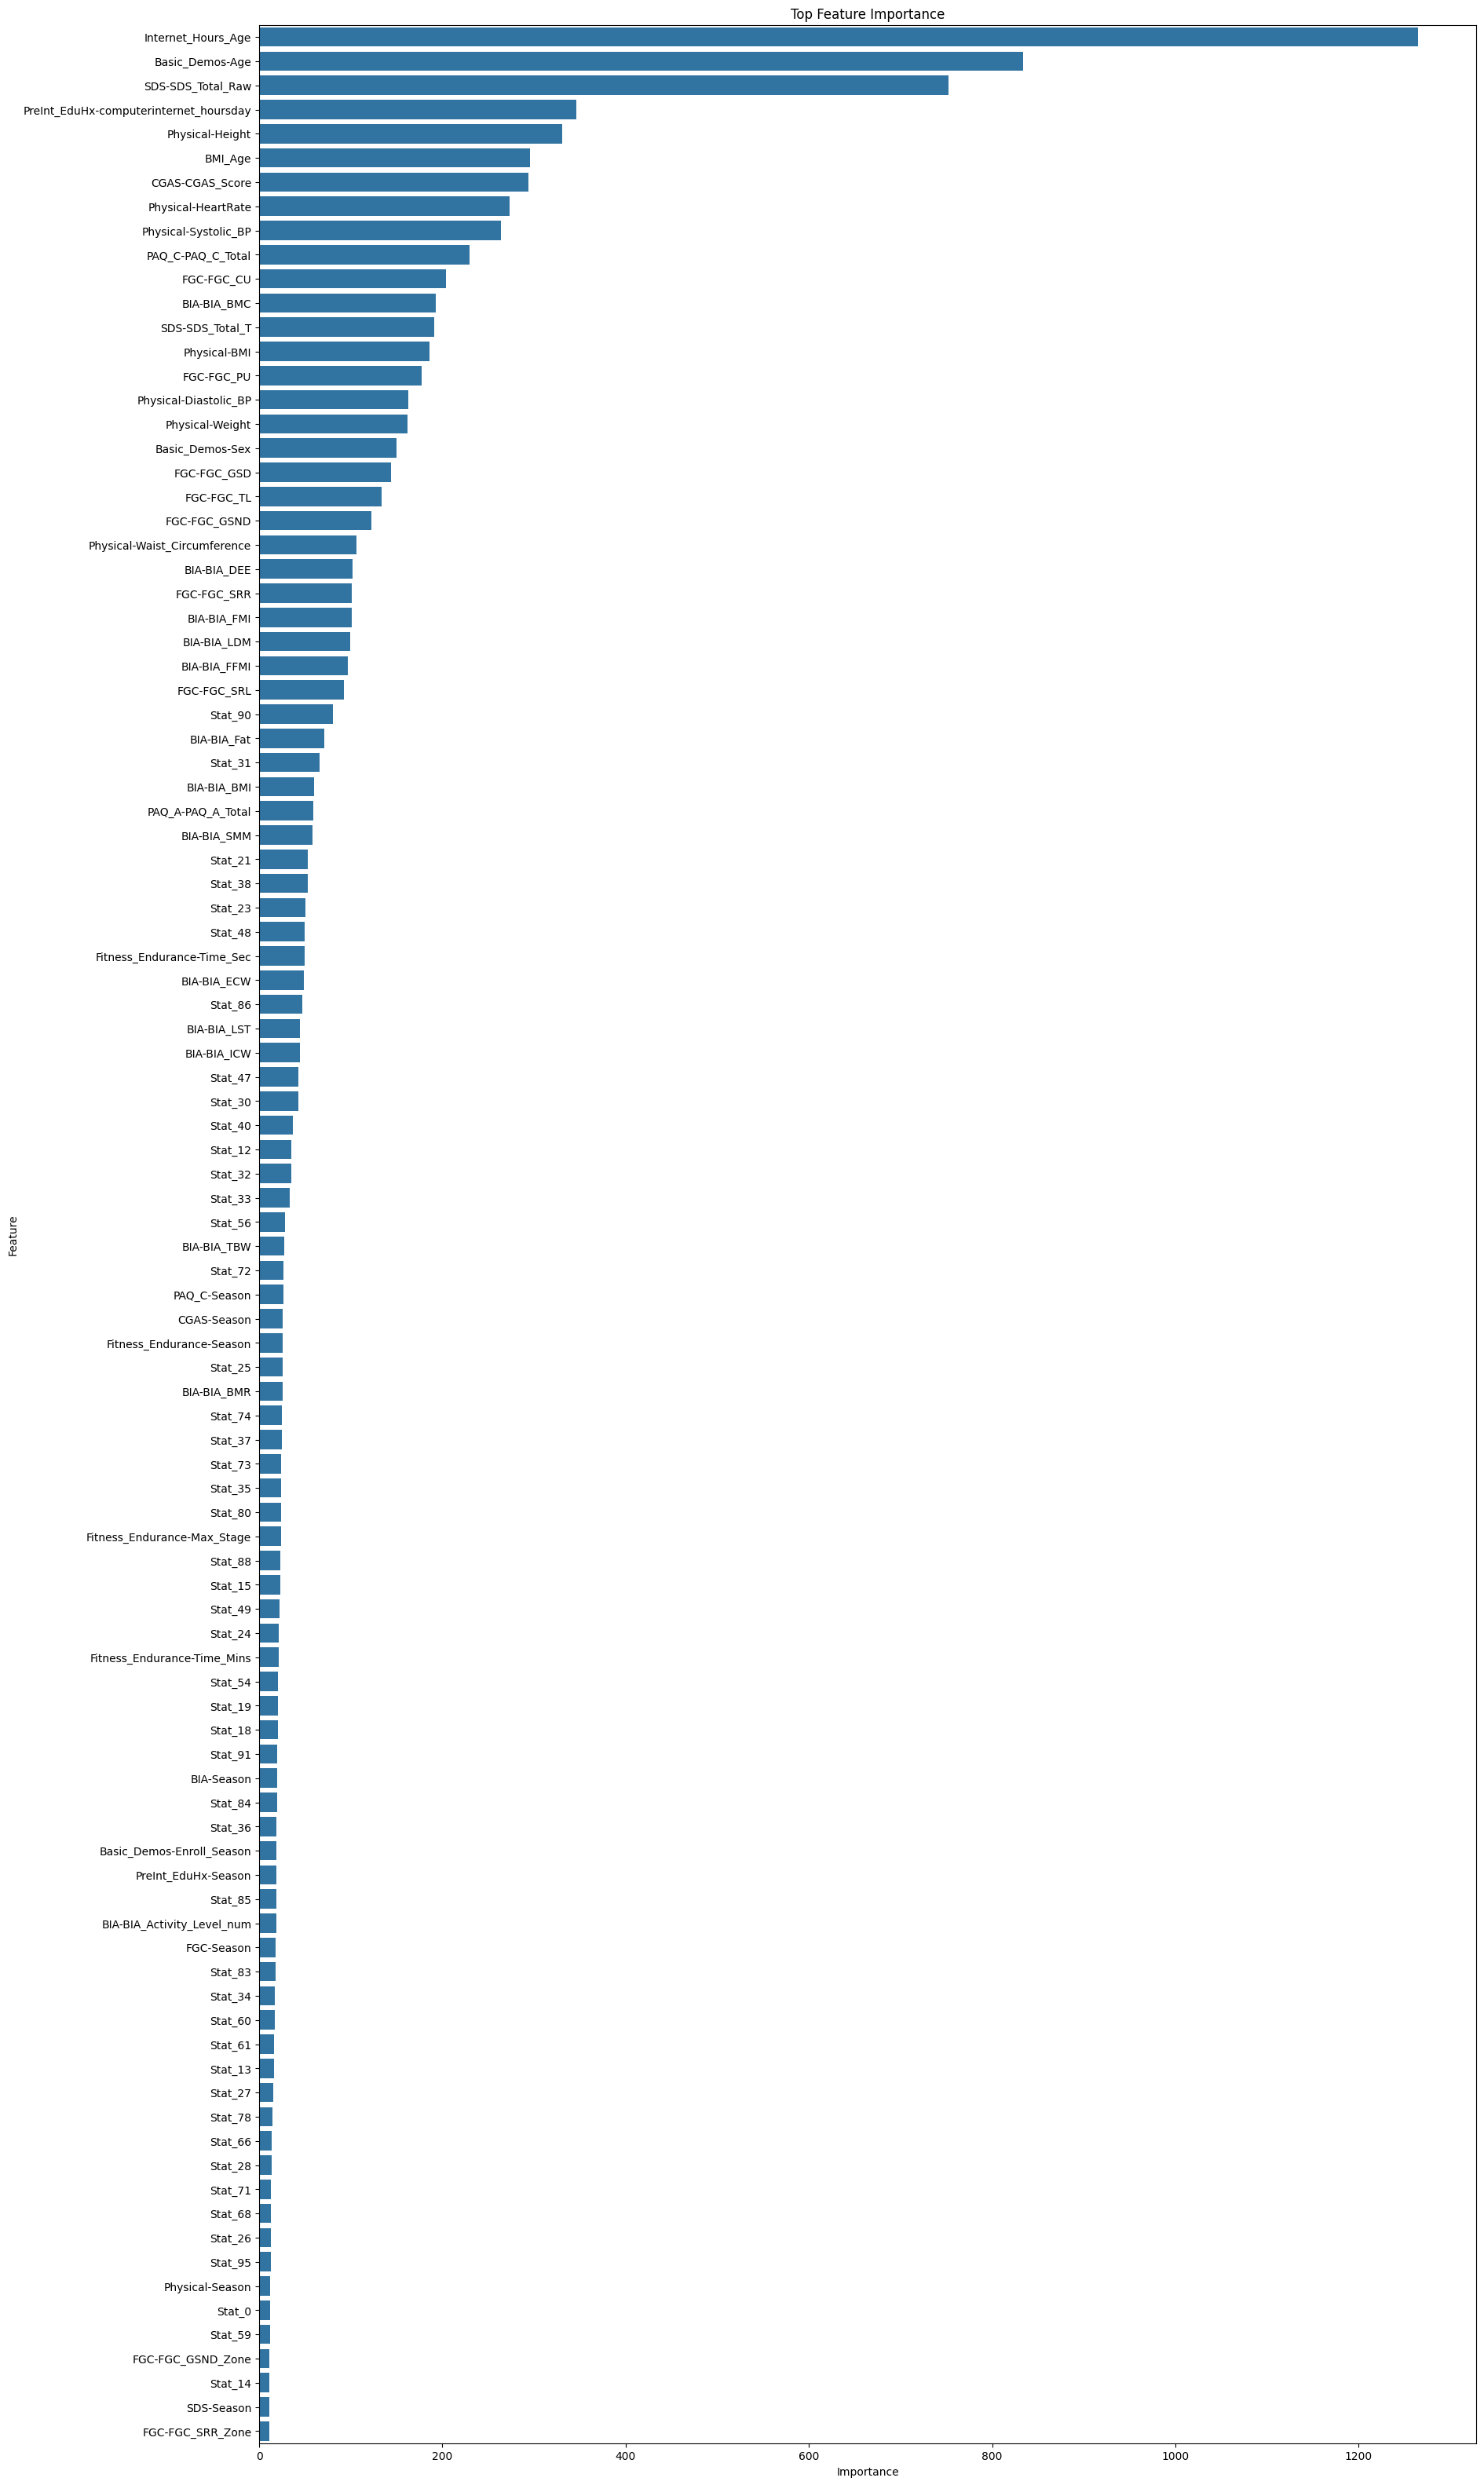

CPU times: user 2.43 s, sys: 150 ms, total: 2.58 s
Wall time: 3.05 s


In [91]:
%%time

feature_importance_df = pd.DataFrame({
    'Feature': model.booster_.feature_name(),
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title("Top Feature Importance")
plt.show()

In [36]:
%%time

# Submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    12
1     7
2     1
Name: count, dtype: int64
CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 5.07 ms
